INTRODUÇÃO:
- A PyWake é uma ferramenta de simulação de parques eólicos de código aberto usada para estudar a interação entre as turbinas dentro de um parque eólico e sua influência no campo de fluxo e na produção de energia do parque. Baseada em Python, a PyWake é capaz de calcular com precisão a física por trás dos parques eólicos, bem como obter sua AEP (Produção Anual de Energia). Ela fornece uma interface unificada para modelos de parques eólicos de diferentes fidelidades, por exemplo, diferentes modelos de engenharia e CFD-RANS (através de um plugin comercial). Dada sua forte vetorização e uso de bibliotecas numéricas, a PyWake é uma ferramenta muito rápida que pode lidar com muitas variáveis simultaneamente.

OBJETIVO:
- O objetivo desse JupyterNotebook é de facilitar e compartilhar o conhecimento sobre a biblioteca PyWake, disponibilizada gratuitamente pela DTU, e suas funcionalidades e utilidades, como: realizar simulações para obter o AEP de um parque eolico, calcular o efeito esteira entre aerogeradores ou até mesmo entre parques.

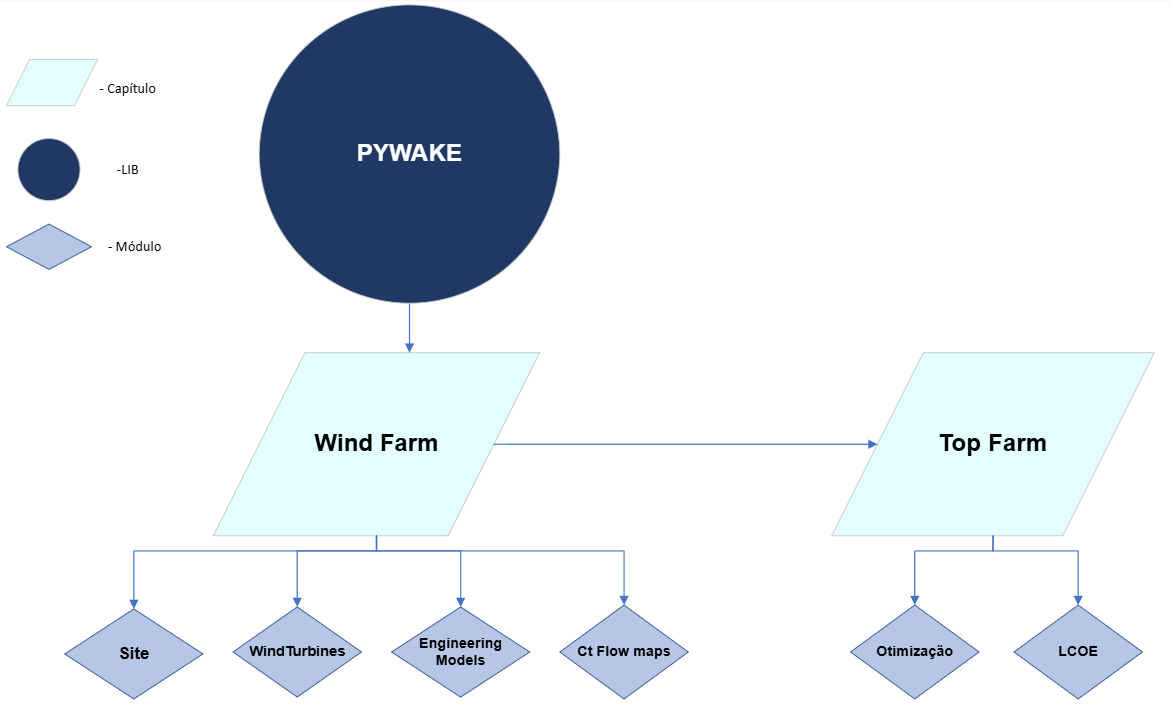
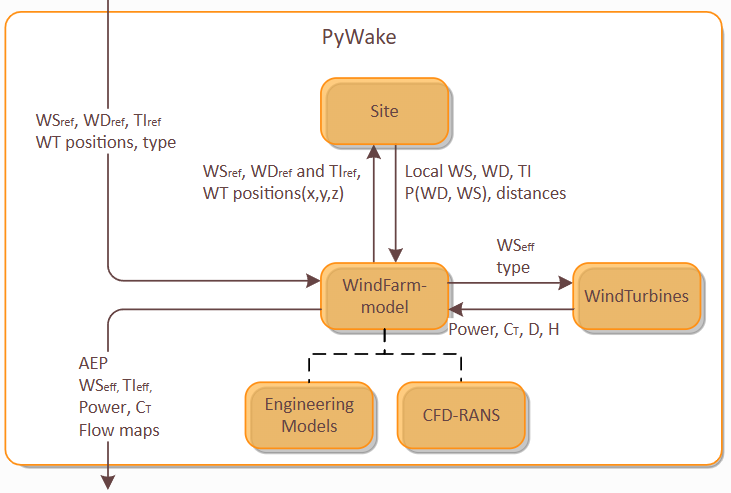

## INSTALAÇÃO
**(topfarm é recomendando para <3.12)**

- conda create --name ENVNAME python=3.11 
- conda activate ENVNAME
- pip install py_wake
- pip install topfarm
- pip install pyproj

In [1]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients

## Wind Farm:
- Ele é o modulo central do pywake, como se fosse o "cérebro" da simulação do Pywake. Ele é responsavel por fazer a simulação do seu parque eolico, baseado no tipo de turbina, no comportamento do vento e as posições das turbinas para poder calcular o seu efeito esteira e geração de energia.

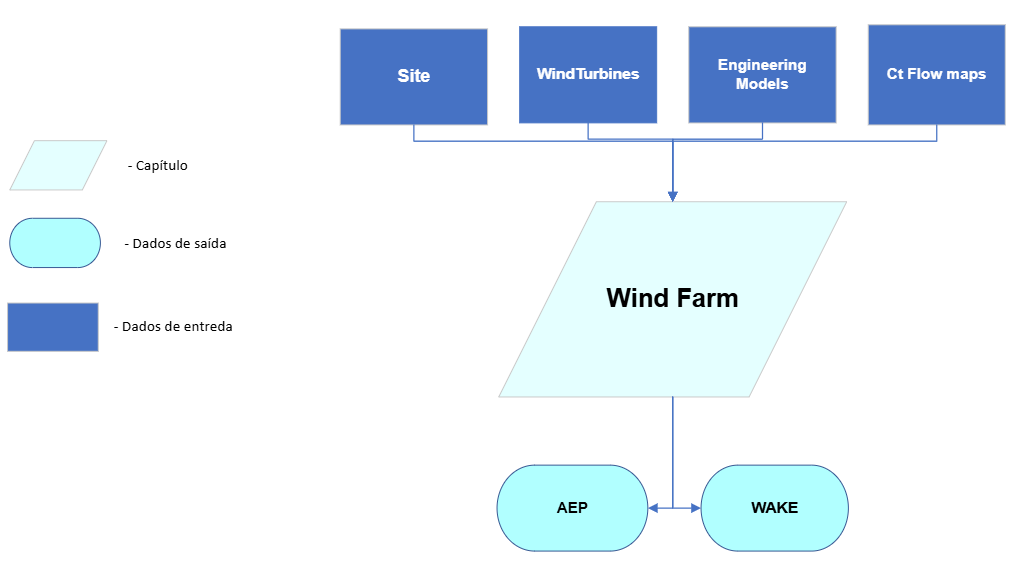
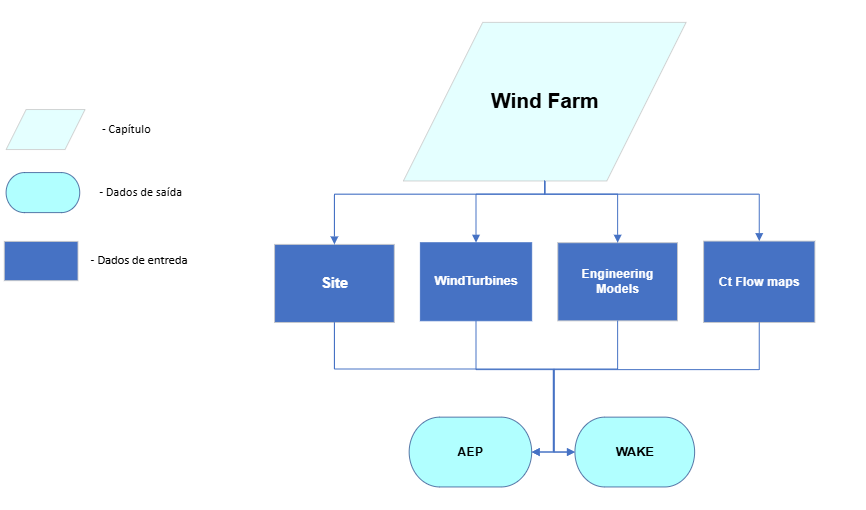

# Etapas para realizar simulação
- Para realizar uma simulação primeiro, temos que descrever as caracteristicas dos ventos do local da simulação e criar a turbina eolica, e descrever as caracteristicas da turbina eolica, que vai ser utilizada para a simulação.

---

## Site:
- Site (o que é): Site é responsavel pela caracterização dos ventos em um determinado local, a velocidade do vento, a direção do vento e sobre a intensidade de turbulencia naquele local.
- Este tópico é responsavel por apresentar o que é um site e como fazemos para criar e especificar os diferentes sites, desde o mais simples(terreno plano) até os mais complexos(terreno irregular).


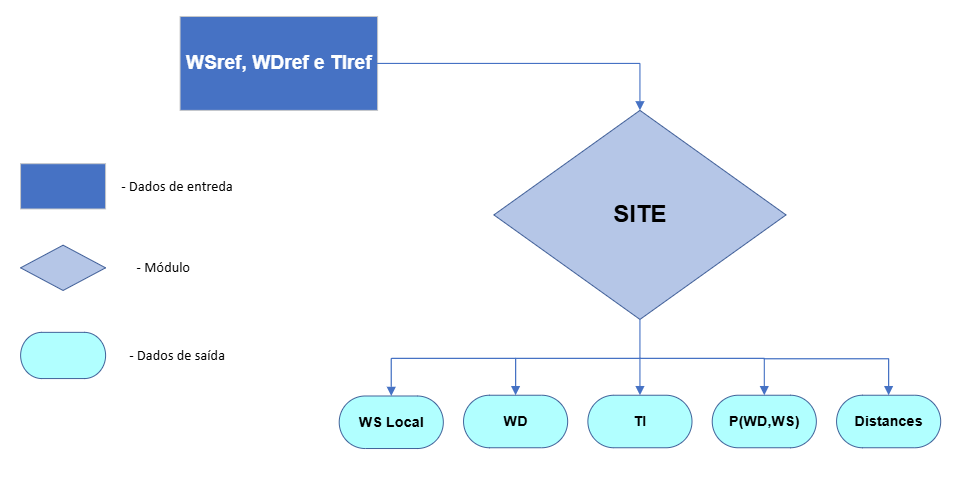

## Apresentação de variaveis:
- ws: Referencia de velocidade de vento, que utilizamos ao criar um site
- wd: Referencia de direção de vento, que utilizamos ao criar um site
- WS: Velocidade do Vento
- WD: Direção do Vento
- TI: Intensidade de Turbulencia
- A: Parametro de Weibull(Scale)
- K: Parametro de Weibull(Shape)
- f: Frequência de ocorrencia do ventos no setor

## Sites predefinidos pelo PyWake:
- IEA37Site: Velocidade do ventos fixa(9,8m/s), probabilidade de vento no setor já é predefinida
- Hornsrev1: Vento uniforme sobre uma área plana, parametros de weibull distribuido na velocidade do vento e probabilidade de vento no setor já é predefinida
- ParqueFicticioSite: Posição dependente da distribuição dos parametros de weibull na velocidaded do vento e a probabilidade de incidencia do vento no setor em terrenos não planos

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite

sites = {"IEA37": IEA37Site(n_wt=16),
         "Hornsrev1": Hornsrev1Site(),
         "ParqueFicticio": ParqueFicticioSite()}

## UniformWeibullSite:
- UniformWeibullSite: Site com os parametros de Weibull uniforme 
- O Exemplo abaixo mostra como fazer as especificações dos parametros necessários

In [4]:
from py_wake.site import UniformWeibullSite

#especificando os parametros necessários para o objeto UniformWeibullSite
site = UniformWeibullSite(p_wd = [.20,.20,.35,.25],                         # Frequencias
                          a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parametro
                          k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parametro
                          ti = 0.1                                          # Intensidade de turbulencia, opcional
                         )

## WaspGridSite:
- WaspGridSite: Site não uniforme baseado em arquivos ".grd"
- Arquivo .grd: Se tratá de um arquivo de grade, arquivo que contém as informações e condições que vão ser utilizadas ao criar esse tipo de site
- Exemplo abaixo mostra como faz essa importação dos arquivos .grd:

In [5]:
from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path

site = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

## XRSite: Dados necessários e opicionais:
- XRSite: Site mais flexivel, a qual é necessário criar um dataset, diferente dos outros modelos de site que já tem seu dataset já predefinido
- Dados opicionais:
- Speedup: Fator que multiplica a ws
- Turning: Oscilações e mudança de direção dos ventos
- p: Probabilidade de fluxos de vento
## Cada dado pode ser variavel ou constante depende da combinação de variaveis a ser utilizadas:
- i: Uma posição por turbina de vento
- x,y: Grade 2D(Como se estivessemos utilizando um ambiente 2D)
- x,y,h: Grade 3D(Como se estivessemos utilizando um ambiente 3D)
- time: Tempo
- wd: Referencia da direção do vento
- ws: Referencia da velocidade do vento

## Exemplo 3:
- Nesse exemplo estamos criando 3 sites diferentes utilizando os objetos que aprendemos acima: UniformWeibullSite, WaspGridSite e um XRSite

- Os tipos de variveis que passamos para criar um site são listas, np.array ou valores numéricos.

In [6]:
from py_wake.site import XRSite
from py_wake.site.shear import PowerShear
import xarray as xr
import numpy as np
from py_wake.utils import weibull
from numpy import newaxis as na

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site com uma velocidade do vento constante, frequências de setor e intensidade de turbulência constantes
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site com vento uniforme sobre uma área plana, parâmetros de Weibull distribuídos na velocidade do vento e probabilidade de vento no setor já é predefinida
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))

# Site com um speedup constante e o valor de turning constante por WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions

complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site com uma grade de informações de speedup
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site com uma ws dependente speedup e wd e ws distribuída probabilidade
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]

complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

## Exemplo 4:
- Agora aplicando os conceitos vistos acima, estamos criando um site e plotando o gráfico de WS num local especifico

Mean wind speed at the mean location: 11.82 m/s


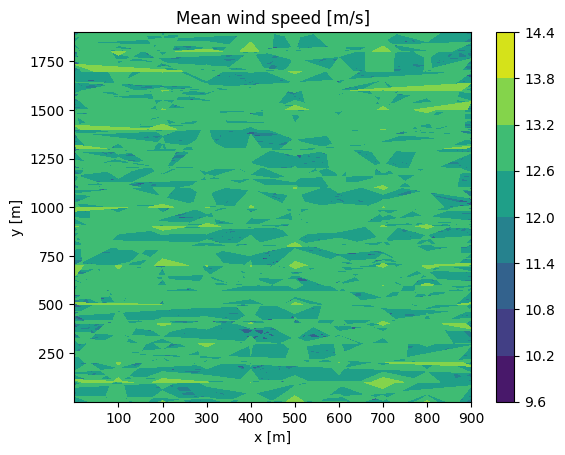

In [7]:
site_x, site_y = np.meshgrid(np.arange(0.1, 1000, 100), np.arange(0.1, 2000, 100))
site_x, site_y = site_x.flatten(), site_y.flatten()
site_time = np.arange(100)
site_ws = np.random.uniform(3.0, 21.0, (len(site_x), len(site_y), len(site_time)))
site_wd = np.random.uniform(0.0, 360.0, (len(site_x), len(site_y), len(site_time)))
ds = xr.Dataset(
    data_vars=dict(
        WS=(["x", "y", "time"], site_ws),
        WD=(["x", "y", "time"], site_wd),
        TI=(["x", "y", "time"], np.ones_like(site_ws) * 0.1),  # hardcoded TI=0.1
        P=1,  # deterministic wind resource
    ),
    coords=dict(
        x=("x", site_x),
        y=("y", site_y),
        time=("time", site_time),
    ),
)
non_uniform_ts_site = XRSite(ds)
wss_at_mean_loc = non_uniform_ts_site.local_wind(
    site_x.mean(), site_y.mean(), time=site_time
)["WS_ilk"]
print(f"Mean wind speed at the mean location: {wss_at_mean_loc.mean():.2f} m/s")

# check the map of the mean wind speed at the site
mean_resource = ds.WS.mean(dim="time").values
plt.contourf(site_x, site_y, mean_resource)
plt.colorbar()
plt.title("Mean wind speed [m/s]")
plt.xlabel("x [m]")
_ = plt.ylabel("y [m]")

- O exemplo mostrou as diferentes velocidade do vento e seus comportamentos em vários pontos do nosso site.

# Obs.:
- Mais afundo no módulo de Site podemos observar, que é possível fazer a simulação do esfeito esteira interferindo outro parque. Essa parte será mas detalhada no tópico de efeito esteira mais a frente.

---

## Wind Turbines: 
- Esse modulo ele é responsavel por apresentar como criar uma turbina eolica, apresentando e mostrando suas variáveis e utilizando turbinas predefinidas pelo Pywake. Mostrando através de uma simulação como a turbina se comporta em diferentes sites.


## Apresentação de Variaveis:
- WSeff: Velocidade do vento efetiva
- Ct: Força exercida no rotor ou motor
- D: Diametro da Turbina
- H: Altura do Hub
- Power: Geração de Energia(Potencia)

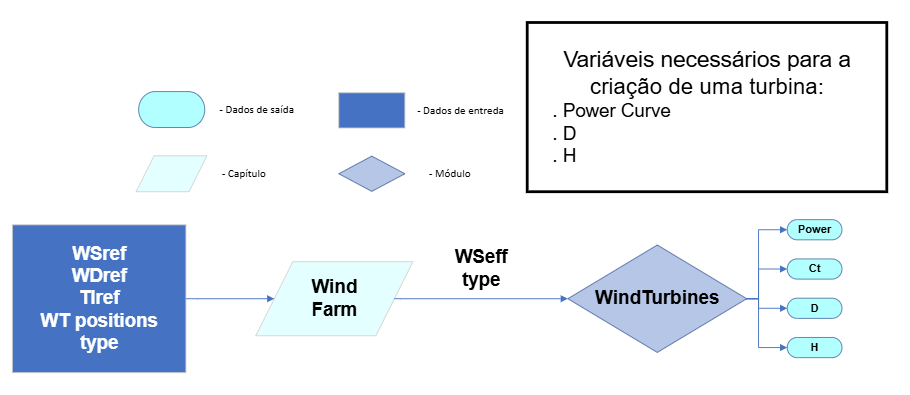
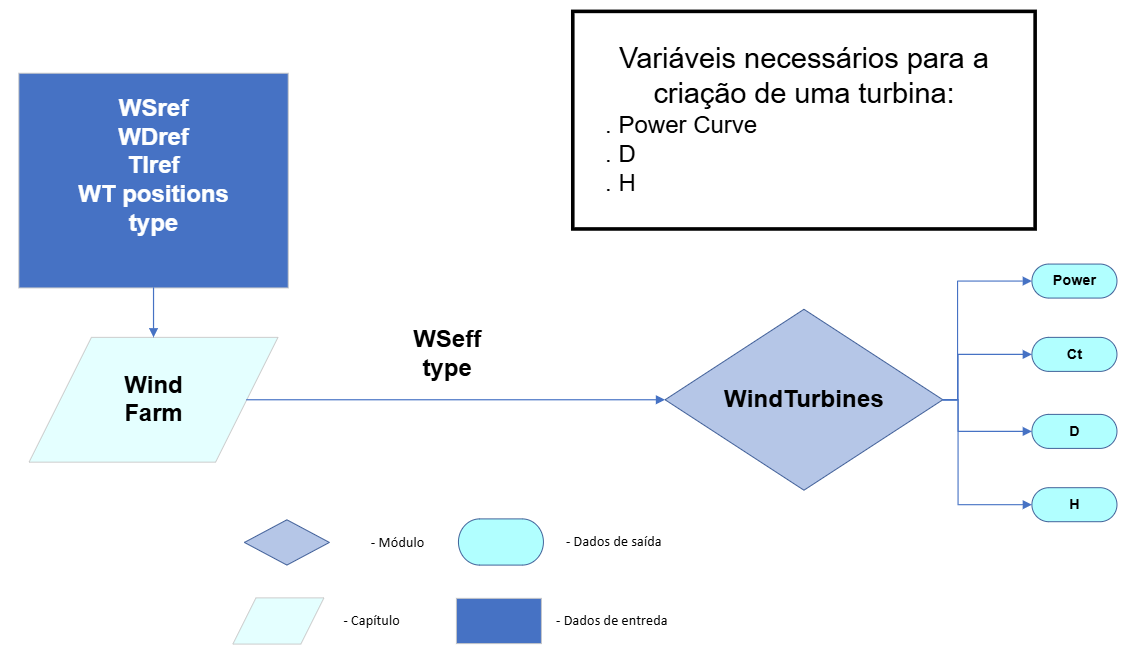

## Turbinas eolicas predefinidas pelo Pywake:
- V80
- 3.35MW
- DTU10MW
- MyWT
- G10MW
- NEG-Micon 2750/92 (2750kW)

- Vamos importar as turbinas já predefinas pelo Pywake:

In [8]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.examples.data.dtu10mw import DTU10MW

v80 = V80()
iea37 = IEA37_WindTurbines()
dtu10mw = DTU10MW()

## Podemos também importar arquivos de turbinas do WAsP .wtg files
- Wtg: Um arquivo com a extensão .wtg(Wind Turbine Generator) é o arquivo de descrição de um aerogerador utilizado pelo software WAsP, que é um dos padrões da indústria para avaliação de recursos eólicos, também desenvolvido pela DTU.

- A estrutura de um arquivo .wtg seria dessa forma:
- WindSpeed="4.0" PowerOutput="55000.0" ThrustCoEfficient="0.871"/><DataPoint WindSpeed="5.0" PowerOutput="185000.0" ThrustCoEfficient="0.853"/><DataPoint WindSpeed="6.0"PowerOutput="369000.0" ThrustCoEfficient="0.841"/><DataPoint WindSpeed="7.0" PowerOutput="619000.0" ThrustCoEfficient="0.841"/><DataPoint WindSpeed="8.0" PowerOutput="941000.0" ThrustCoEfficient="0.833"/><DataPoint WindSpeed="9.0" PowerOutput="1326000.0" ThrustCoEfficient="0.797"/><DataPoint WindSpeed="10.0" PowerOutput="1741000.0" ThrustCoEfficient="0.743"/><DataPoint WindSpeed="11.0" PowerOutput="2133000.0" ThrustCoEfficient="0.635"/><DataPoint WindSpeed="12.0" PowerOutput="2436000.0" ThrustCoEfficient="0.543"/><DataPoint WindSpeed="13.0" PowerOutput="2617000.0"

In [9]:
import os

In [10]:
from py_wake.examples.data import wtg_path

wtg_file = os.path.join(wtg_path, 'NEG-Micon-2750.wtg')
neg2750 = WindTurbine.from_WAsP_wtg(wtg_file)

# Exemplo 1:
- Nesse exemplo criaremos uma turbina eolica, especificando o CT e a potencia da turbina que criaremos

- Os tipos de variveis que passamos para criar uma turbina também são listas, como apresentado mostrado no módulo de site.

In [11]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

u = [0,3,12,25,30]
ct = [0,8/9,8/9,.3, 0]
power = [0,0,2000,2000,0]

my_wt = WindTurbine(name='MyWT',
                    diameter=123,
                    hub_height=321,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

- PyWake tem uma classe de turbina eolica generica, a qual faz a turbina onde o power é computado por um modelo analitico baseado no diametro e no "nominal power"

# Exemplo 2: Esse modelo aceita varios inputs opicionais como:
- air_density= 1.225 kg/m
- max_cp= .49
- constant_ct= .8
- gear_loss_const= .01
- gear_loss_var= .014
- generator_loss= 0.03
- converter_loss= .03

In [12]:
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

#for a diameter of 178.3m and hub height of 119m
gen_wt = GenericWindTurbine('G10MW', 178.3, 119, power_norm=10000, turbulence_intensity=.1)

# Exemplo 3:
- Vamos criar a lista de diferentes turbinas e vamos listar, o nome das turbinas, seu diametro e altura do hub

In [13]:
wts = WindTurbines.from_WindTurbine_lst([v80,iea37,dtu10mw,my_wt,gen_wt,neg2750])

In [14]:
types = wts.types()
print("Name:\t\t%s" % "\t".join(wts.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str, wts.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str, wts.hub_height(type=types))))

Name:		V80	3.35MW	DTU10MW	MyWT	G10MW	NEG-Micon 2750/92 (2750 kW)
Diameter[m]	80.0	130.0	178.3	123.0	178.3	92.0
Hubheigt[m]	70.0	110.0	119.0	321.0	119.0	70.0


# Curvas de Potencia e curvas de CT
- Curva de Potencia: A curva de potência é uma curva que mostra quanto de energia a turbina consegue gerar a partir de certa velocidade do vento.
- Curva de CT: A curva de CT é a curva, que mostra a força do vento exercida no rotor.
- Nesse modulo explicamos, como é feito os cálculos de curva de potência e as curvas de CT.

# Exemplo 4:
- Agora vamos plotar num gráfico todas as turbinas que definimos acima
- Primeiro vamos plotar a curva de potencia de cada turbina

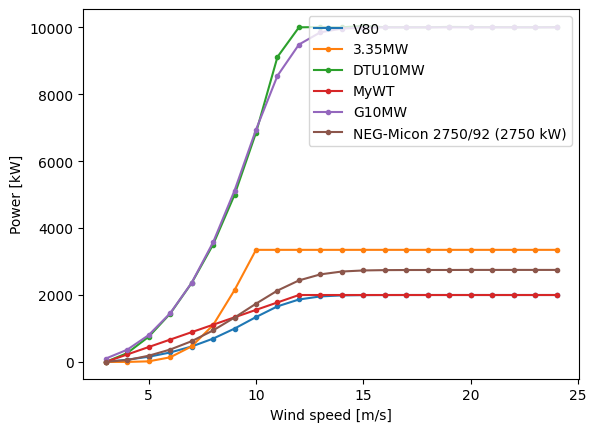

In [15]:
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')

for t in types:
    plt.plot(ws, wts.power(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)

- O exemplo acima mostra a curva de potência de cada turbina, e como podemos observar a turbina DTU10MW é a que consegue captar mais energia a partir de 12m/s

- Agora vamos plotar a curva de ct

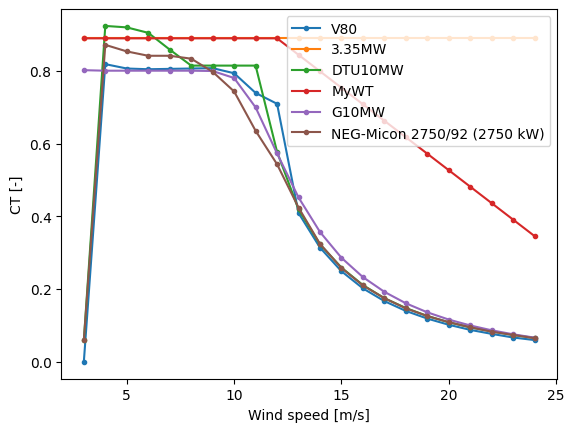

In [16]:
plt.xlabel('Wind speed [m/s]')
plt.ylabel('CT [-]')

for t in types:
    plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
plt.legend(loc=1)

- Então podemos observar a curva de Ct em cada turbina, a qual o ponto de decaimento da força da turbina é diferente para cada tipo de turbina.

- Podemos também plotar gráficos multidimensionais de curva de potencia e ct
- Alguns arquivos WAsP wtg, define multiplos modos de turbinas de vento, por exemplo a turbina "Vestas V112-3.0 MW.wtg" tem 12 modos representando diferentes niveis de desendidade do ar, nesse caso o modo padrão é o 0


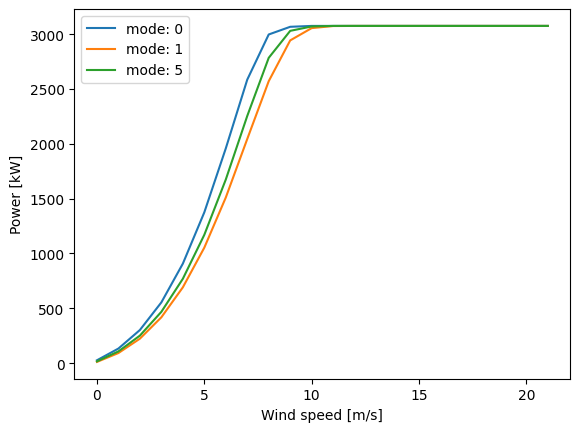

In [17]:
wtg_file = os.path.join(wtg_path, 'Vestas V112-3.0 MW.wtg')
v112 = WindTurbine.from_WAsP_wtg(wtg_file)


#selecionando os modos da turbina
for m in [0,1,5]:
    plt.plot(v112.power(ws, mode=m)/1000, label=f'mode: {m}')

p0,ct0 = v112.power_ct(ws, mode=0)
p1,ct1 = v112.power_ct(ws, mode=1)

plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

---

## AEP(Produção anual de energia):
- AEP é a quantidade total acumulada de energia que uma única turbina ou um parque eólico inteiro gerou ao longo de um ano completo.

## Exemplo: Calculo de AEP
O Exemplo abaixo mostra como fazer o calculo de AEP

In [18]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80, wt_x, wt_y, wt16_x, wt16_y
from py_wake import NOJ

#here we import the turbine, site and wake deficit model to use.
windTurbines = V80()
site = Hornsrev1Site()
noj = NOJ(site,windTurbines)

In [19]:
simulationResult = noj(wt16_x,wt16_y)

In [20]:
simulationResult.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 16, wd: 360, ws: 23)> Size: 1MB
array([[[0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        ...,
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]],

       [[0.00000000e+00, 3.21704038e-05, 1.07631358e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.50325965e-05, 1.13318710e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.81343279e-05, 1.19482041e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
...
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.70626513e-05, 9.95068465e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.73276423e-05, 1.00421384e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]],

       [[0.00000000e+00, 3.69047609e-05, 1.05287023e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.86957286e-05, 1.12417512e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.06849605e-05, 1.19260253e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        ...,
        [0.00000000e+00, 3.54284013e-05, 9.86539322e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.54109110e-05, 9.85789848e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.55351507e-05, 9.93005262e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]]],
      shape=(16, 360, 23))
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * wt       (wt) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    type     (wt) int64 128B 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

## Exemplo 2: Selecionando uma turbina
- O Exemplo abaixo estamos fazendo o mesmo calculo de AEP feito acima, mas selecionando só uma turbina eolica

In [21]:
simulationResult.sel(wt=2)

<xarray.SimulationResult> Size: 346kB
Dimensions:           (wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    wt                int64 8B 2
    type              int64 8B 0
Data variables: (12/17)
    WS_eff            (wd, ws) float64 66kB 3.0 3.777 4.546 ... 23.87 24.88
    TI_eff            (wd, ws) float64 66kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Power             (wd, ws) float64 66kB 0.0 5.174e+04 ... 2e+06 2e+06
    CT                (wd, ws) float64 66kB 0.0 0.6355 ... 0.06094 0.05386
    h                 float64 8B 70.0
    x                 int64 8B 424111
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.177 9.177 ... 9.177 9.177 9.177
    Weibull_k         (wd) float64 3kB 2.393 2.393 2.393 ... 2.393 2.393 2.393
    Sector_frequency  (wd) float64 3kB 0.001199 0.001199 ... 0.001199 0.001199
    P                 (wd, ws) float64 66kB 6.147e-05 8.559e-05 ... 2.193e-08

In [22]:
print(f"Total AEP: {float(simulationResult.Power.sel(wt=2).sum().values)/1e9:.2f} GWh")

Total AEP: 11.88 GWh


## PLOTANDO GRÁFICO DE AEP (UTILIZANDO WT, WD E WS)

Text(0.5, 1.0, 'Wake map for 10 m/s and 270 deg')

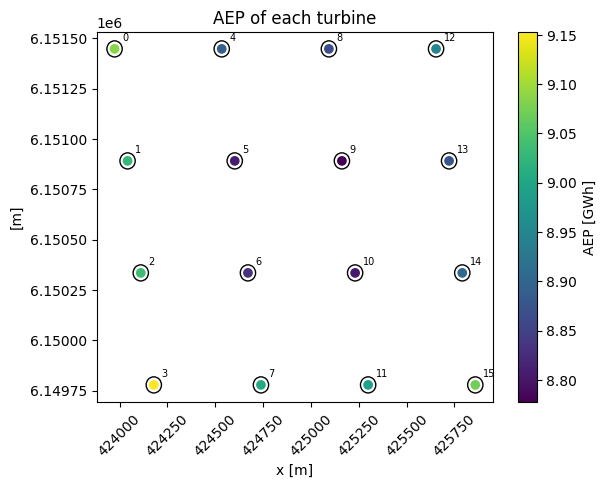

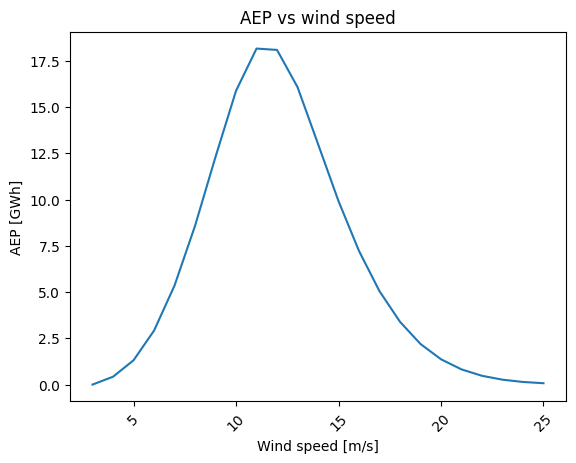

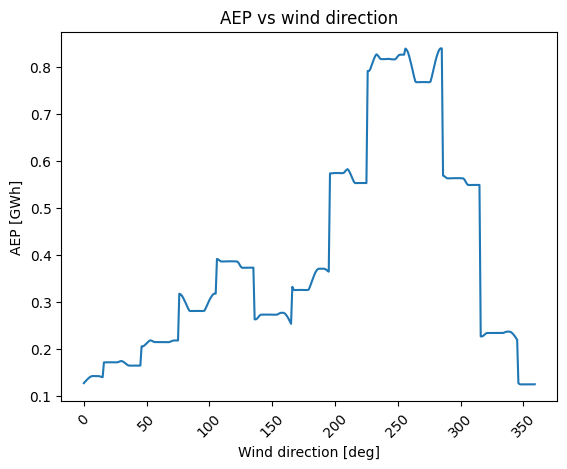

<Figure size 640x480 with 0 Axes>

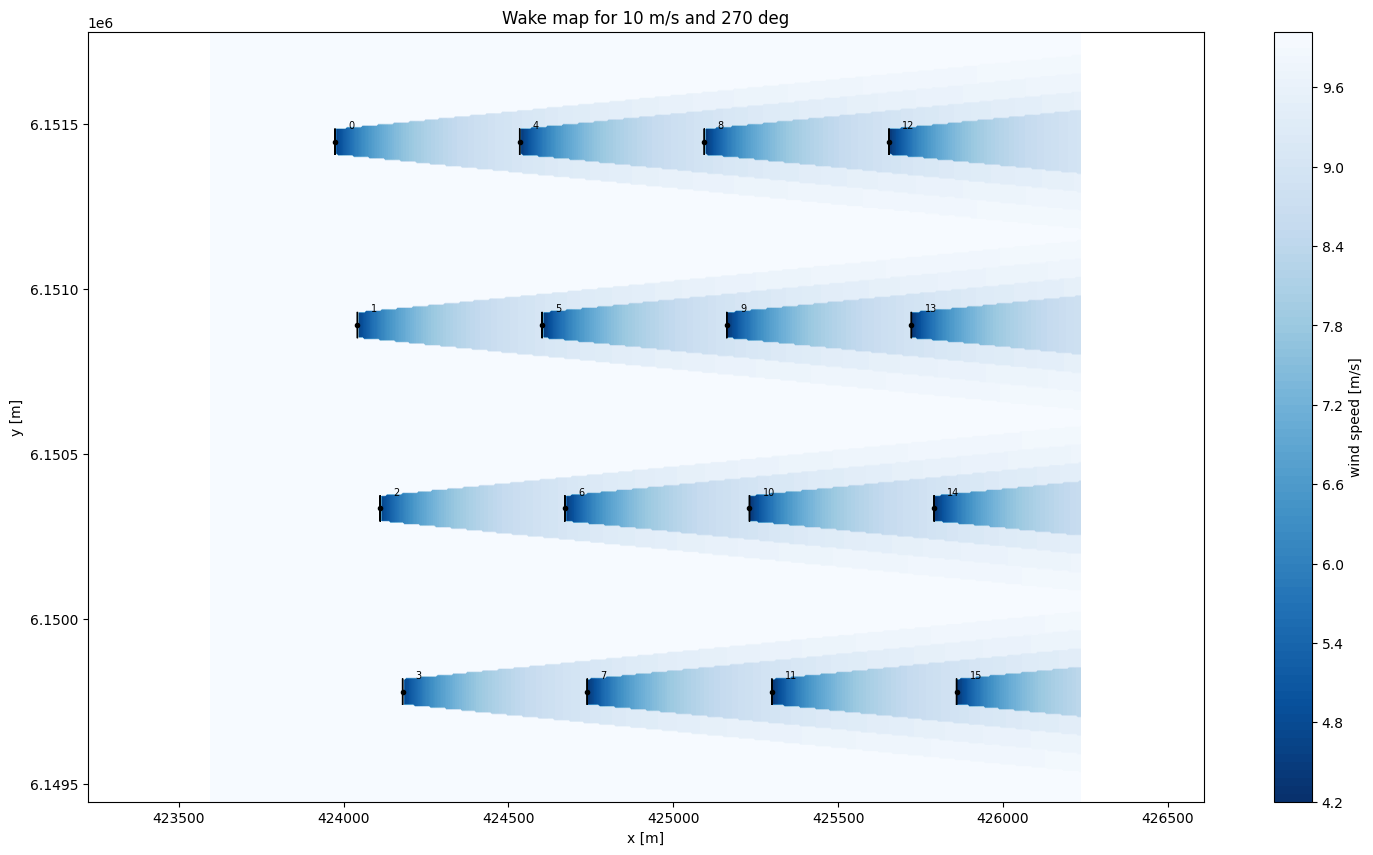

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotando o AEP de cada turbina
plt.figure()
aep = simulationResult.aep()
windTurbines.plot(wt16_x, wt16_y)
c =plt.scatter(wt16_x, wt16_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.xticks(rotation=45)

#Gráfico AEP vs Velocidade do Vento
plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')
plt.xticks(rotation=45)

#Gráfico AEP vs Direção do Vento
plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')
plt.xticks(rotation=45)

#Gráfico wind farm, para visualizar o comportamento de cada turbina
wind_speed = 10
wind_direction = 270

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

- O gráfico 1, está mostrando a produção anual de energia de cada turbina e sua posição no site.
- O gráfico 2, mostra o quanto de energia está sendo produzido em determinada velocidade do vento.
- O gráfico 3, sinaliza à direção do vento com maior produção de energia.
- O gráfico 4, faz uma simulação de esfeito esteira no nosso parque e como influência na velocidade de cada turbina.

---

# Efeito esteira:
- O modulo de efeito esteira é responsavel, por calcular o efeito esteira causado por uma turbina eolica.

# Modelos de efeito esteira predefinidos pelo Pywake:
- NOJDeficit
- TurboNOJDeficit
- FugaDeficit
- BastankhahGaussianDeficit
- IEA37SimpleBastankhahGaussianDeficit
- NiayifarGaussianDeficit
- ZongGaussianDeficit
- CarbojofuertesGaussianDeficit
- TurboGaussianDeficit
- GCLDeficit
- SuperGaussianDeficit

- Agora vamos importar todos os modelos de efeito esteira predefinidos pelo pywake:

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import py_wake

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

from py_wake import NOJ
from py_wake import Fuga
from py_wake import FugaBlockage
from py_wake import BastankhahGaussian

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

models = {'NOJ': NOJ(site,windTurbines),
          'Fuga': Fuga(lut_path,site,windTurbines),
          'FugaBlockage': FugaBlockage(lut_path,site,windTurbines),
          'BGaus': BastankhahGaussian(site,windTurbines)
         }

C:\Users\arthurfreire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\py_wake\deficit_models\gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


- Abaixo mostra como criar o seu modelo de simulção de efeito esteira:

In [25]:
from py_wake.superposition_models import LinearSum

models['NOJLinear'] = NOJ(site,windTurbines,superpositionModel=LinearSum())

In [26]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit

models['NOJ_ss'] = All2AllIterative(site,windTurbines,
                                          wake_deficitModel=NOJDeficit(),
                                          superpositionModel=LinearSum(),
                                          blockage_deficitModel=SelfSimilarityDeficit())

# Exemplo 1:
- Mostraremos a seguir vários exemplos de efeito esteira, com suas caracteristicas e diferenças:

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_wake_deficit_map(model):
    cmap = np.r_[[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap))

# NOJDeficit:
- É um dos modelos mais simples e clássicos. Ele representa a esteira de uma maneira mais retangular, com um déficit de velocidade uniforme que se expande linearmente a jusante. É principalmente utilizado para o campo distante da esteira.

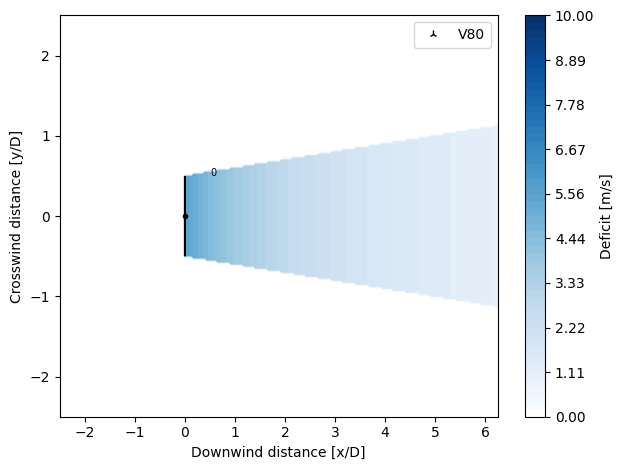

In [28]:
from py_wake.deficit_models import NOJDeficit
plot_wake_deficit_map(NOJDeficit())

# TurboNOJDeficit:
- Uma variação do modelo NOJ, provavelmente ajustado para melhor corresponder a certas condições ou resultados experimentais, embora detalhes específicos não estivessem proeminentes nos resultados da pesquisa.

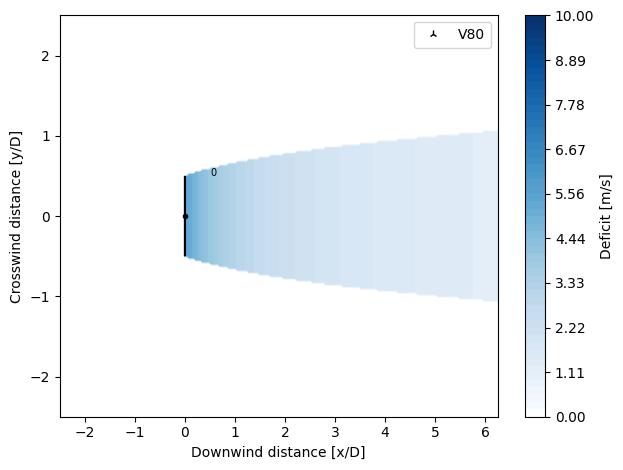

In [29]:
from py_wake.deficit_models import TurboNOJDeficit
plot_wake_deficit_map(TurboNOJDeficit())

# BastankhahGaussianDeficit:
- Este é um modelo popular que assume um perfil de velocidade Gaussiano para a esteira. A recuperação da velocidade segue uma forma de sino, o que é uma representação mais realista do que o modelo retangular do NOJ. É válido para o campo distante da esteira.

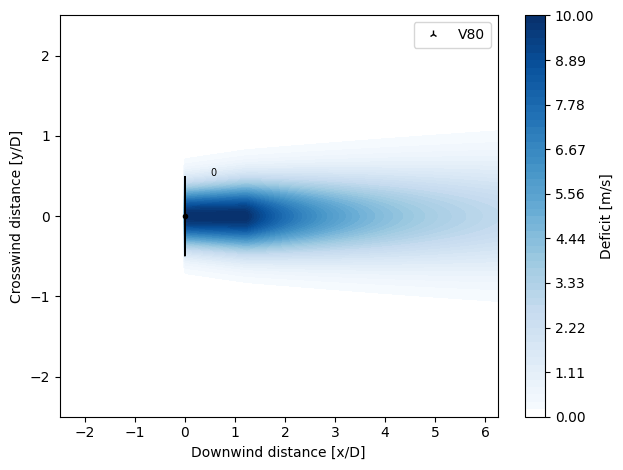

In [30]:
from py_wake.deficit_models import BastankhahGaussianDeficit
plot_wake_deficit_map(BastankhahGaussianDeficit())

# IEA37SimpleBastankhahGaussianDeficit:
- Uma variação do modelo BastankhahGaussian, provavelmente simplificada ou calibrada especificamente para o caso de estudo da IEA Task 37.

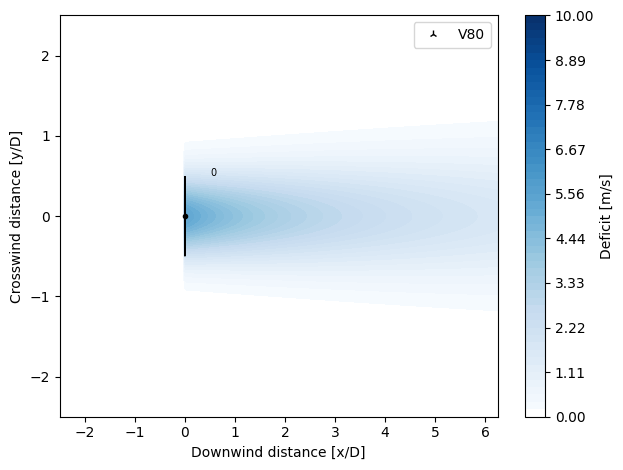

In [31]:
from py_wake.deficit_models import IEA37SimpleBastankhahGaussianDeficit
plot_wake_deficit_map(IEA37SimpleBastankhahGaussianDeficit())

# NiayifarGaussianDeficit:
- Um modelo Gaussiano onde a expansão da esteira é também função da intensidade da turbulência local.

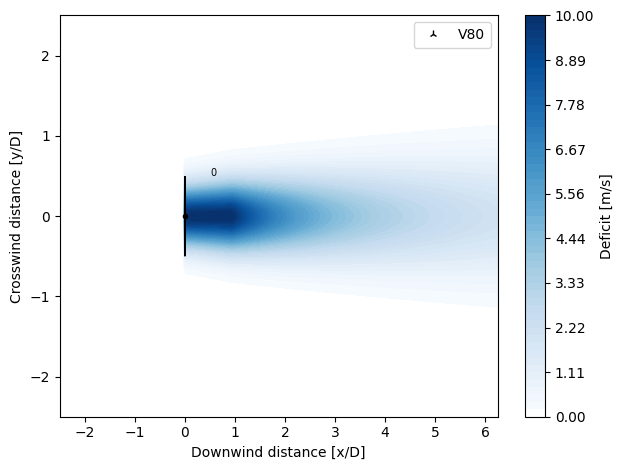

In [32]:
from py_wake.deficit_models import NiayifarGaussianDeficit
plot_wake_deficit_map(NiayifarGaussianDeficit(a=[0.38, 4e-3]))

# ZongGaussianDeficit:
- Outro modelo de perfil Gaussiano, baseado no NiayifarGaussianDeficit, também tem a função da intensiade da intensidade da turbulência local. É notável por ser aplicável também ao campo próximo da esteira.

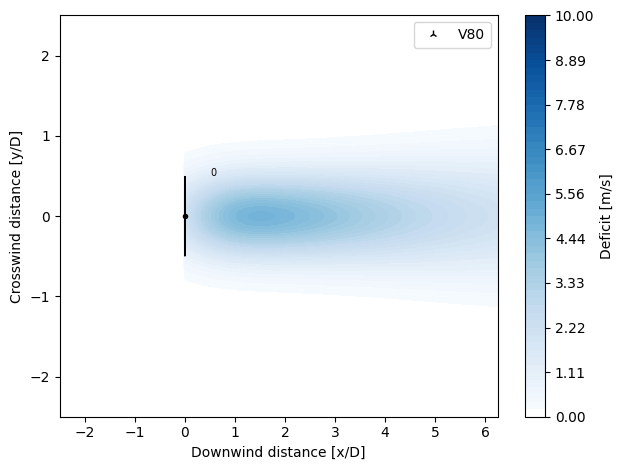

In [33]:
from py_wake.deficit_models import ZongGaussianDeficit
plot_wake_deficit_map(ZongGaussianDeficit(a=[0.38, 4e-3]))

# CarbajoFuertesGaussianDeficit:
- Se trata de uma versão modificada do ZongGaussianDeficit, utilizando constantes Gaussianas.

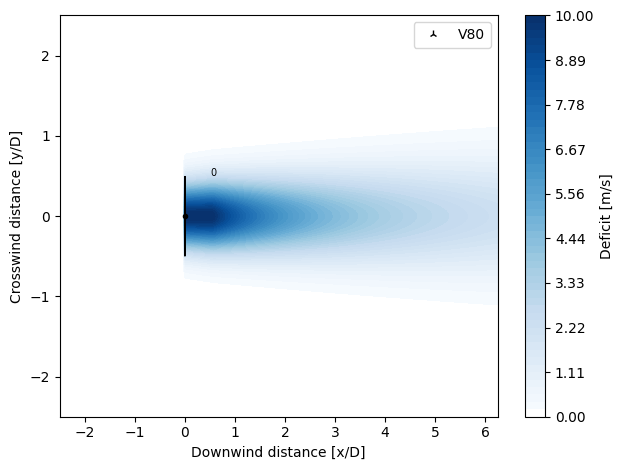

In [34]:
from py_wake.deficit_models import CarbajofuertesGaussianDeficit
plot_wake_deficit_map(CarbajofuertesGaussianDeficit())

# TurboGaussianDeficit:
- O modelo calcula o efeito esteira de maneira similar ao TurboNOJDeficit, com a destinção que utiliza o shape Gaussiano para a expanção do efeito esteira.

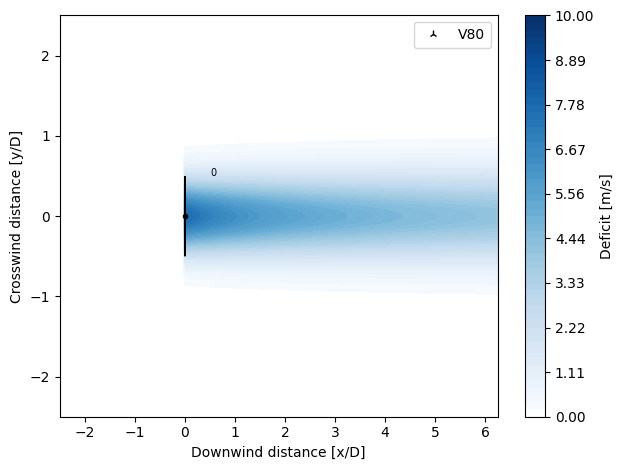

In [35]:
from py_wake.deficit_models import TurboGaussianDeficit
plot_wake_deficit_map(TurboGaussianDeficit())

# SuperGaussianDeficit:
- Um modelo que utiliza uma função super-Gaussiana para descrever o déficit de velocidade, sendo também aplicável ao campo próximo da esteira.

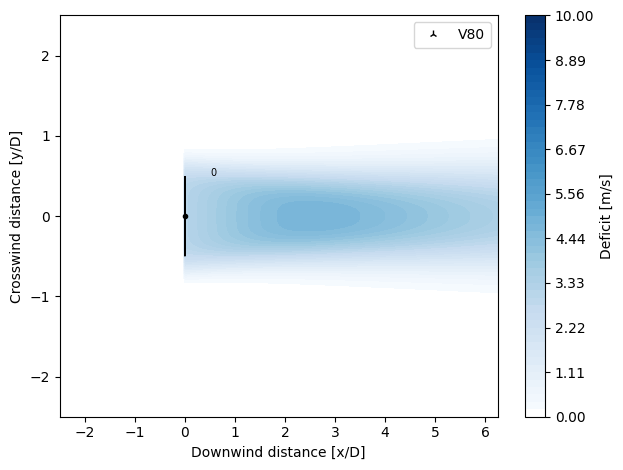

In [36]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
plot_wake_deficit_map(BlondelSuperGaussianDeficit2020())

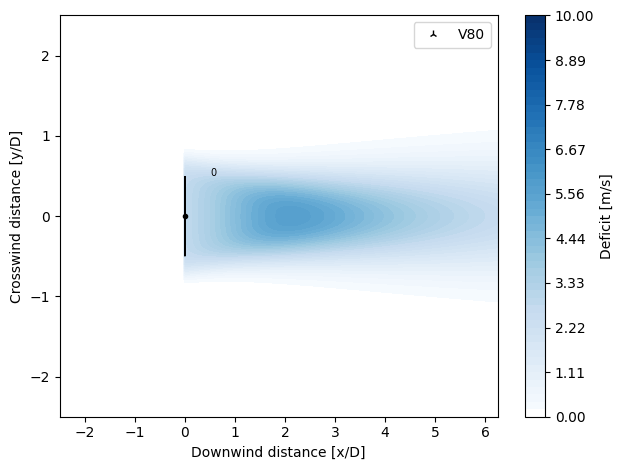

In [37]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2023
plot_wake_deficit_map(BlondelSuperGaussianDeficit2023())

# FugaDeficit:
- Este modelo utiliza uma abordagem diferente. Ele calcula o déficit de esteira com base em tabelas de consulta (look-up tables) pré-computadas por um solver RANS (Reynolds-Averaged Navier-Stokes) linearizado. O FugaDeficit também é capaz de simular o efeito de bloqueio (blockage).

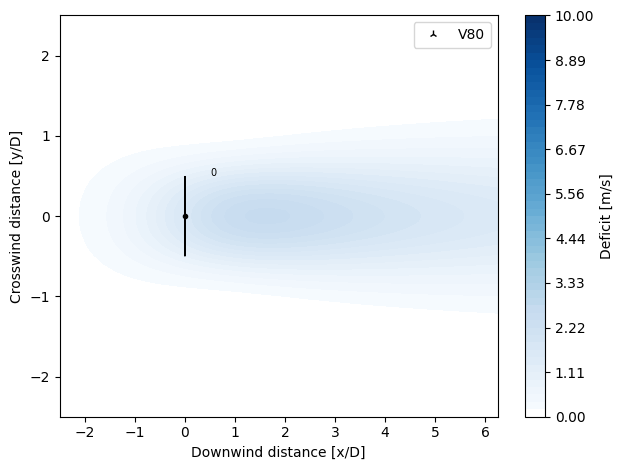

In [38]:
import py_wake
from py_wake.deficit_models import FugaDeficit

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

plot_wake_deficit_map(FugaDeficit(lut_path))

# GCLDeficit:
- O modelo é baseado em uma solução analítica de uma versão simplificada das equações de Navier-Stokes (NS). Ele assume que a esteira de vento é perfeitamente circular e que o vento que atinge a turbina é uniforme. A expansão da esteira é calculada de forma aproximada, usando dados empíricos que dependem de dois fatores: o empuxo do rotor e a turbulência do ambiente.

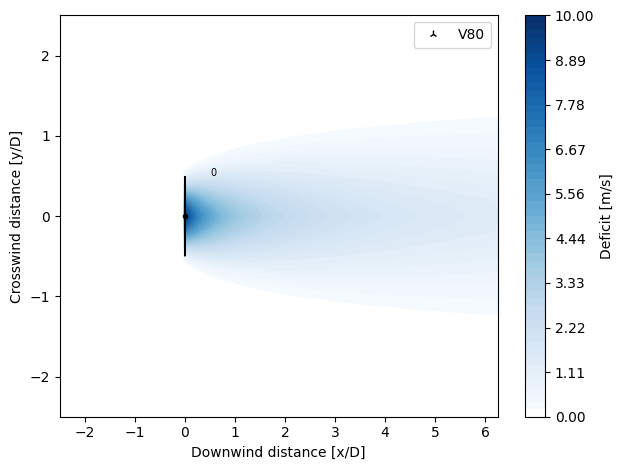

In [39]:
from py_wake.deficit_models import GCLDeficit
plot_wake_deficit_map(GCLDeficit())

---

# Vamos à prática:
- Aqui vamos criar um site e fazer o calculo de produção de AEP, e o efeito esteira de cada turbina

In [118]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients

In [119]:
import os
import numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines import WindTurbine, WindTurbines

- Primeiro vamos criar a nossa turbina

In [120]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
df=pd.read_csv('2020ATB_NREL_Reference_7MW_200.csv')
ws= df['Wind Speed [m/s]']
power=df['Power [kW]']
ct= df['Ct [-]']
wt = WindTurbine(
                name='NREL_7MW_200',
                diameter=200,
                hub_height=119,
                powerCtFunction=PowerCtTabular(ws,power,'kW',ct))


- Vamos passar as variaveis necessarias para podermos fazer o site

In [121]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = [.1]*12

In [122]:
#Weibull_A = np.array(A)
#Weibull_k = np.array(k)
#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"

ds = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', A),
        'Weibull_k': ('wd', k),
        'TI': ('wd', ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
    }
)

In [123]:
ds

<xarray.Dataset> Size: 480B
Dimensions:           (wd: 12)
Coordinates:
  * wd                (wd) float64 96B 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    Sector_frequency  (wd) float64 96B 0.036 0.039 0.052 ... 0.147 0.1 0.052
    Weibull_A         (wd) float64 96B 9.177 9.782 9.532 ... 11.69 11.64 10.09
    Weibull_k         (wd) float64 96B 2.393 2.447 2.412 ... 2.607 2.627 2.326
    TI                (wd) float64 96B 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1

- Para calcular o AEP do nosso site utilizaremos o NOJ como Wind Farm Model, para fazer o cálculo(como mostrado no primeiro exemplo calculando o AEP)

In [124]:
from py_wake import NOJ
windTurbines = wt
site = XRSite(ds)
wfm = NOJ(site, windTurbines)

- Passando as posições das turbinas:

In [125]:
imy_4wt_x= [123, 250, 492, 615, 800, 900]
imy_4wt_y= [123, 150, 492, 615, 800, 900]
# Abaixo outro metodo de passar as coordenadas, transformando os valores acima, em um arrays numpy.
#i4 é responsavel por passar a ordem de cada turbina, que são plotadas no gráfico e pela quantidade de turbinas.
i4= [0, 1, 2, 3, 4, 5]
my_wt4_x= np.array(imy_4wt_x)[i4]
my_wt4_y= np.array(imy_4wt_y)[i4]

- Vamos utilizar o imy_4wt_x e imy_4wt_y:

In [126]:
simulaçaoResult= wfm(imy_4wt_x, imy_4wt_y)

In [127]:
simulaçaoResult

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 6, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 48B 0 1 2 3 4 5
    type              (wt) int64 48B 0 0 0 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 397kB 3.0 3.821 4.744 ... 24.0 25.0
    TI_eff            (wt, wd, ws) float64 397kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 397kB 0.0 3.369e+05 ... 7e+06 0.0
    CT                (wt, wd, ws) float64 397kB 0.0 0.3124 ... 0.02632 0.0
    h                 (wt) float64 48B 119.0 119.0 119.0 119.0 119.0 119.0
    x                 (wt) int64 48B 123 250 492 615 800 900
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.197 9.217 ... 9.268 9.238 9.207
    Weibull_k         (wd) float64 3kB 2.393 2.395 2.397 ... 2.386 2.389 2.391
    Sector_frequency  (wd) float64 3kB 0.0012 0.001203 ... 0.001236 0.001218
    P                 (wd, ws) float64 66kB 6.15e-05 8.565e-05 ... 2.45e-08

In [128]:
simulaçaoResult.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 6, wd: 360, ws: 23)> Size: 397kB
array([[[0.00000000e+00, 2.52794736e-04, 6.82790366e-04, ...,
         8.65538098e-06, 3.50986800e-06, 0.00000000e+00],
        [0.00000000e+00, 2.51757500e-04, 6.80716438e-04, ...,
         8.93812466e-06, 3.63458008e-06, 0.00000000e+00],
        [0.00000000e+00, 2.50710596e-04, 6.78583055e-04, ...,
         9.22869944e-06, 3.76311105e-06, 0.00000000e+00],
        ...,
        [0.00000000e+00, 2.60454551e-04, 7.03719810e-04, ...,
         1.13715359e-05, 4.75403385e-06, 0.00000000e+00],
        [0.00000000e+00, 2.57956947e-04, 6.96869678e-04, ...,
         1.03969953e-05, 4.30330586e-06, 0.00000000e+00],
        [0.00000000e+00, 2.55403467e-04, 6.89904035e-04, ...,
         9.49294044e-06, 3.88940039e-06, 0.00000000e+00]],

       [[0.00000000e+00, 3.00103607e-04, 8.14576434e-04, ...,
         8.65538098e-06, 3.50986800e-06, 0.00000000e+00],
        [0.00000000e+00, 2.99419689e-04, 8.13495619e-04, ...,
         8.93812466e-06, 3.63458008e-06, 0.00000000e+00],
        [0.00000000e+00, 2.98222806e-04, 8.10939922e-04, ...,
         9.22869944e-06, 3.76311105e-06, 0.00000000e+00],
...
         1.13715359e-05, 4.75403385e-06, 0.00000000e+00],
        [0.00000000e+00, 2.35987449e-04, 6.40497001e-04, ...,
         1.03969953e-05, 4.30330586e-06, 0.00000000e+00],
        [0.00000000e+00, 2.32687706e-04, 6.31179564e-04, ...,
         9.49294044e-06, 3.88940039e-06, 0.00000000e+00]],

       [[0.00000000e+00, 3.00103607e-04, 8.14576434e-04, ...,
         8.65538098e-06, 3.50986800e-06, 0.00000000e+00],
        [0.00000000e+00, 2.99419689e-04, 8.13495619e-04, ...,
         8.93812466e-06, 3.63458008e-06, 0.00000000e+00],
        [0.00000000e+00, 2.98733942e-04, 8.12404197e-04, ...,
         9.22869944e-06, 3.76311105e-06, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.07752304e-04, 8.35829042e-04, ...,
         1.13715359e-05, 4.75403385e-06, 0.00000000e+00],
        [0.00000000e+00, 3.05236273e-04, 8.28840409e-04, ...,
         1.03969953e-05, 4.30330586e-06, 0.00000000e+00],
        [0.00000000e+00, 3.02686915e-04, 8.21756728e-04, ...,
         9.49294044e-06, 3.88940039e-06, 0.00000000e+00]]],
      shape=(6, 360, 23))
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * wt       (wt) int64 48B 0 1 2 3 4 5
    type     (wt) int64 48B 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

- É possível printar só o "simulaçãoResult", para visualizar a matriz com suas variaveis, para visualizar selecionamos a opção "Data variables", que mostrara todos as variaveis da matriz.

In [129]:
print(simulationResult)

<xarray.SimulationResult> Size: 4MB
Dimensions:           (wt: 16, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    type              (wt) int64 128B 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 1MB 3.0 4.0 5.0 ... 22.85 23.86 24.87
    TI_eff            (wt, wd, ws) float64 1MB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 1MB 0.0 6.66e+04 ... 2e+06 2e+06
    CT                (wt, wd, ws) float64 1MB 0.0 0.818 ... 0.06096 0.05388
    h                 (wt) float64 128B 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0
    x                 (wt) int64 128B 423974 424042 424111 ... 425791 425859
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.

In [130]:
simulaçaoResult

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 6, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 48B 0 1 2 3 4 5
    type              (wt) int64 48B 0 0 0 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 397kB 3.0 3.821 4.744 ... 24.0 25.0
    TI_eff            (wt, wd, ws) float64 397kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 397kB 0.0 3.369e+05 ... 7e+06 0.0
    CT                (wt, wd, ws) float64 397kB 0.0 0.3124 ... 0.02632 0.0
    h                 (wt) float64 48B 119.0 119.0 119.0 119.0 119.0 119.0
    x                 (wt) int64 48B 123 250 492 615 800 900
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.197 9.217 ... 9.268 9.238 9.207
    Weibull_k         (wd) float64 3kB 2.393 2.395 2.397 ... 2.386 2.389 2.391
    Sector_frequency  (wd) float64 3kB 0.0012 0.001203 ... 0.001236 0.001218
    P                 (wd, ws) float64 66kB 6.15e-05 8.565e-05 ... 2.45e-08

- Podemos selecionar para mostrar só uma das variaveis da matriz, como mostra abaixo.

In [131]:
simulaçaoResult['Weibull_A']

<xarray.DataArray 'Weibull_A' (wd: 360)> Size: 3kB
array([ 9.177     ,  9.19716667,  9.21733333,  9.2375    ,  9.25766667,
        9.27783333,  9.298     ,  9.31816667,  9.33833333,  9.3585    ,
        9.37866667,  9.39883333,  9.419     ,  9.43916667,  9.45933333,
        9.4795    ,  9.49966667,  9.51983333,  9.54      ,  9.56016667,
        9.58033333,  9.6005    ,  9.62066667,  9.64083333,  9.661     ,
        9.68116667,  9.70133333,  9.7215    ,  9.74166667,  9.76183333,
        9.782     ,  9.77366667,  9.76533333,  9.757     ,  9.74866667,
        9.74033333,  9.732     ,  9.72366667,  9.71533333,  9.707     ,
        9.69866667,  9.69033333,  9.682     ,  9.67366667,  9.66533333,
        9.657     ,  9.64866667,  9.64033333,  9.632     ,  9.62366667,
        9.61533333,  9.607     ,  9.59866667,  9.59033333,  9.582     ,
        9.57366667,  9.56533333,  9.557     ,  9.54866667,  9.54033333,
        9.532     ,  9.5446    ,  9.5572    ,  9.5698    ,  9.5824    ,
        9.595     ,  9.6076    ,  9.6202    ,  9.6328    ,  9.6454    ,
        9.658     ,  9.6706    ,  9.6832    ,  9.6958    ,  9.7084    ,
        9.721     ,  9.7336    ,  9.7462    ,  9.7588    ,  9.7714    ,
        9.784     ,  9.7966    ,  9.8092    ,  9.8218    ,  9.8344    ,
        9.847     ,  9.8596    ,  9.8722    ,  9.8848    ,  9.8974    ,
        9.91      ,  9.91443333,  9.91886667,  9.9233    ,  9.92773333,
        9.93216667,  9.9366    ,  9.94103333,  9.94546667,  9.9499    ,
...
       11.591     , 11.6006    , 11.6102    , 11.6198    , 11.6294    ,
       11.639     , 11.6486    , 11.6582    , 11.6678    , 11.6774    ,
       11.687     , 11.68533333, 11.68366667, 11.682     , 11.68033333,
       11.67866667, 11.677     , 11.67533333, 11.67366667, 11.672     ,
       11.67033333, 11.66866667, 11.667     , 11.66533333, 11.66366667,
       11.662     , 11.66033333, 11.65866667, 11.657     , 11.65533333,
       11.65366667, 11.652     , 11.65033333, 11.64866667, 11.647     ,
       11.64533333, 11.64366667, 11.642     , 11.64033333, 11.63866667,
       11.637     , 11.58536667, 11.53373333, 11.4821    , 11.43046667,
       11.37883333, 11.3272    , 11.27556667, 11.22393333, 11.1723    ,
       11.12066667, 11.06903333, 11.0174    , 10.96576667, 10.91413333,
       10.8625    , 10.81086667, 10.75923333, 10.7076    , 10.65596667,
       10.60433333, 10.5527    , 10.50106667, 10.44943333, 10.3978    ,
       10.34616667, 10.29453333, 10.2429    , 10.19126667, 10.13963333,
       10.088     , 10.05763333, 10.02726667,  9.9969    ,  9.96653333,
        9.93616667,  9.9058    ,  9.87543333,  9.84506667,  9.8147    ,
        9.78433333,  9.75396667,  9.7236    ,  9.69323333,  9.66286667,
        9.6325    ,  9.60213333,  9.57176667,  9.5414    ,  9.51103333,
        9.48066667,  9.4503    ,  9.41993333,  9.38956667,  9.3592    ,
        9.32883333,  9.29846667,  9.2681    ,  9.23773333,  9.20736667])
Coordinates:
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359

- Como também pode se selecionar a turbina, a velocidade e a direção a qual queremos ver dessa varivel.

In [132]:
simulaçaoResult.sel(wt=2, wd=150, ws=10)['WS_eff']

<xarray.DataArray 'WS_eff' ()> Size: 8B
array(10.)
Coordinates:
    ws       int64 8B 10
    wd       int64 8B 150
    wt       int64 8B 2
    type     int64 8B 0
Attributes:
    Description:  Effective local wind speed [m/s]

- Agora vamos plotar no gráfico

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700'),
  Text(800.0, 0, '800'),
  Text(900.0, 0, '900'),
  Text(1000.0, 0, '1000')])

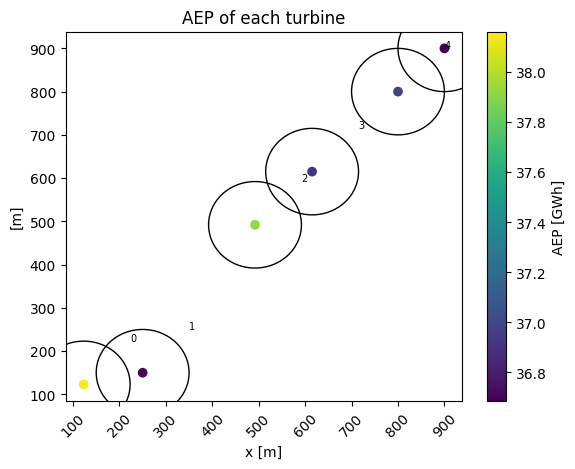

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotando o AEP de cada turbina
plt.figure()
aep = simulaçaoResult.aep()
windTurbines.plot(my_wt4_x, my_wt4_y)
c =plt.scatter(my_wt4_x, my_wt4_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.xticks(rotation=45)

In [134]:
simulaçaoResult.sel(wt=2)

<xarray.SimulationResult> Size: 349kB
Dimensions:           (wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    wt                int64 8B 2
    type              int64 8B 0
Data variables: (12/17)
    WS_eff            (wd, ws) float64 66kB 3.0 3.808 4.724 ... 22.91 23.92 25.0
    TI_eff            (wd, ws) float64 66kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Power             (wd, ws) float64 66kB 0.0 3.323e+05 ... 7e+06 0.0
    CT                (wd, ws) float64 66kB 0.0 0.3115 0.3569 ... 0.02659 0.0
    h                 float64 8B 119.0
    x                 int64 8B 492
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.197 9.217 ... 9.268 9.238 9.207
    Weibull_k         (wd) float64 3kB 2.393 2.395 2.397 ... 2.386 2.389 2.391
    Sector_frequency  (wd) float64 3kB 0.0012 0.001203 ... 0.001236 0.001218
    P                 (wd, ws) float64 66kB 6.15e-05 8.565e-05 ... 2.45e-08

- Agora vamos simular o efeito esteira do nosso site

- Primeiro temos que criar o nosso modelo de windfarm, e escolher o modelo de esfeito esteira que vamos utilizar.
- Nesse exemplo utilizaremos o efeito BastankhahGaussianDeficit.

In [135]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum
from py_wake.deficit_models import SelfSimilarityDeficit2020

wf_model = All2AllIterative(site,wt,
                            wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),)
                            #superpositionModel=LinearSum(),)
                            #blockage_deficitModel=SelfSimilarityDeficit2020())

- Vamos criar um tipo de simulação passando primeiro as posições, em seguida passamos ao wf_model as posições criadas e a direção, que queremos simular o efeito esteira

In [136]:
x= [-1250,123, 250, 492, 715, 900, 1200]
y= [1750,123, 1600, 492, 715, 939, 1200]
simulaçaoResult_2 = wf_model(x, y, wd=150)

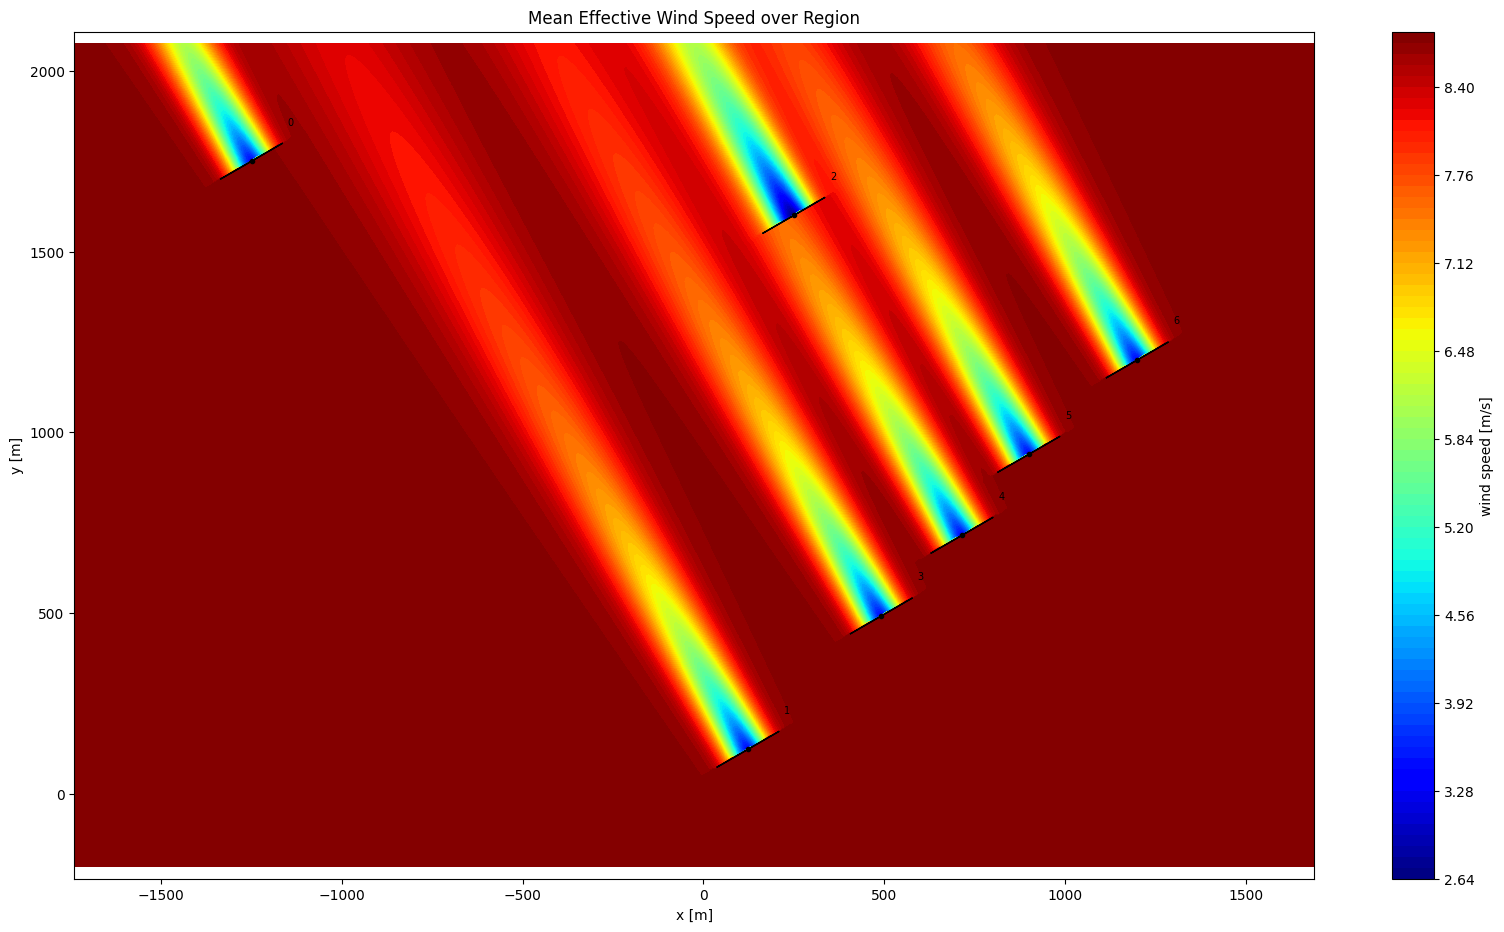

In [137]:
flow = simulaçaoResult_2.flow_map()
plt.figure(figsize=(20, 11))
flow.plot_wake_map(cmap='jet')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()

---

# Superposição

- Superposição calcula a efetividade da velocidade do vento, dado a velocidade local do vento e seu efeito esteira. ** editar
- Esse capítulo é responsável por mostrar os modelos de superposição e descrevelos.

# Módelos de superposições:

- LinearSum: É a abordagem mais simples. O déficit de velocidade total em um ponto é a soma direta dos déficits de velocidade individuais de todas as esteiras que o afetam.
- SquaredSum: O déficit de velocidade total é calculado como a raiz quadrada da soma dos quadrados dos déficits individuais.
- MaxSum: Neste método, o déficit de velocidade total em um ponto é simplesmente o maior déficit de todas as esteiras que o afetam. Ele assume que a esteira dominante sobrepõe as outras.
- WeightedSum: Esse modelo utiliza uma soma ponderada, onde cada déficit individual é multiplicado por um fator que pode depender da intensidade da esteira, da turbulência, da distância, etc., antes de serem combinados.
- SqrMaxSum: É considerada a raiz quadrada da intensidade da turbulência local e o valor máximo da turbulência adicionada causada pela turbina de origem.

In [138]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020
from py_wake.turbulence_models import CrespoHernandez
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

# LinearSum:

Text(0, 0.5, 'y [m]')

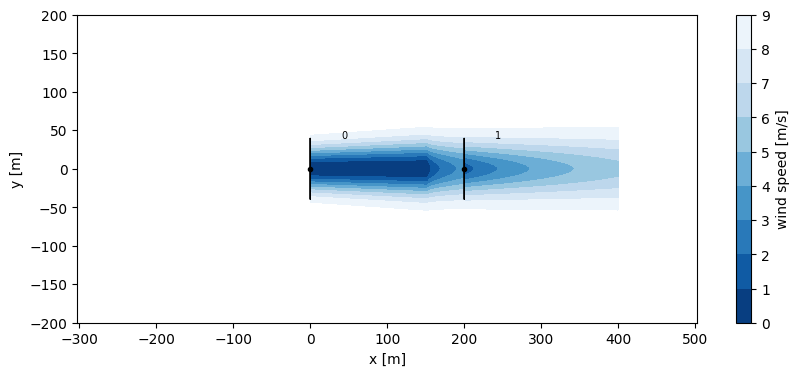

In [139]:
from py_wake.superposition_models import LinearSum

linear_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=LinearSum(), use_effective_ws=True)
plt.figure(figsize=(10,4))
linear_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# SquaredSum:

Text(0, 0.5, 'y [m]')

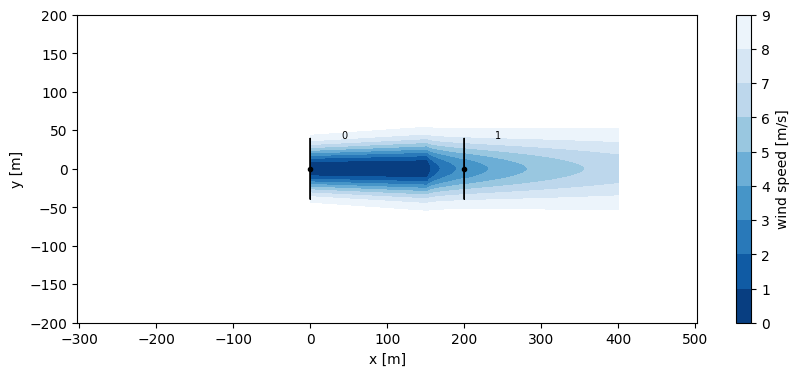

In [140]:
from py_wake.superposition_models import SquaredSum

squared_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=SquaredSum())
plt.figure(figsize=(10,4))
squared_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# MaxSum:

Text(0, 0.5, 'y [m]')

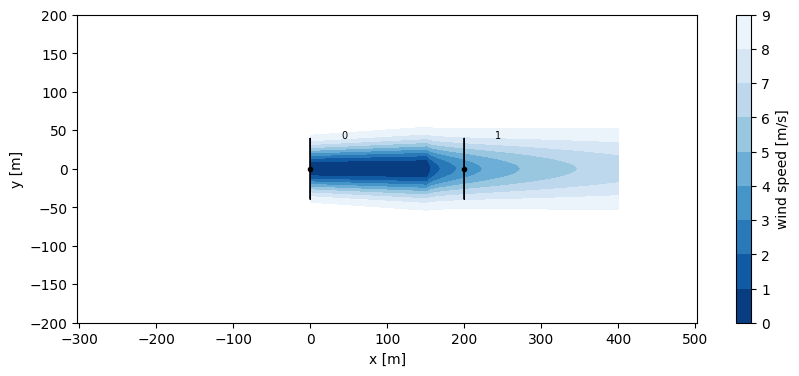

In [141]:
from py_wake.superposition_models import MaxSum

max_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=MaxSum())
plt.figure(figsize=(10,4))
max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# WeightedSum:

Text(0, 0.5, 'y [m]')

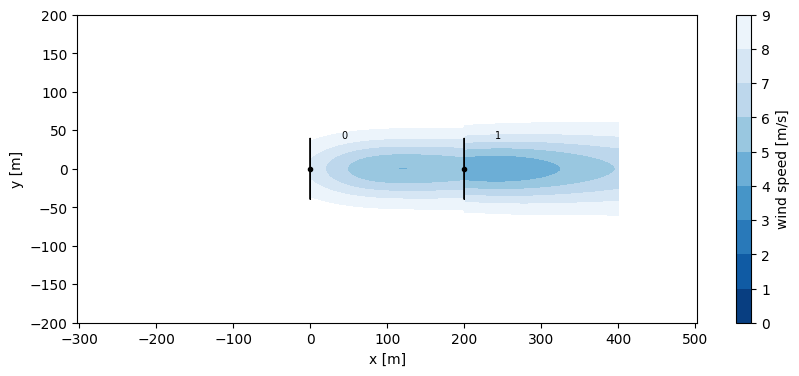

In [142]:
from py_wake.superposition_models import WeightedSum

weighted_sum = Zong_PorteAgel_2020(site, windTurbines, use_effective_ws=True, superpositionModel=WeightedSum())

plt.figure(figsize=(10,4))
weighted_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# SqrMaxSum:

Text(0, 0.5, 'y [m]')

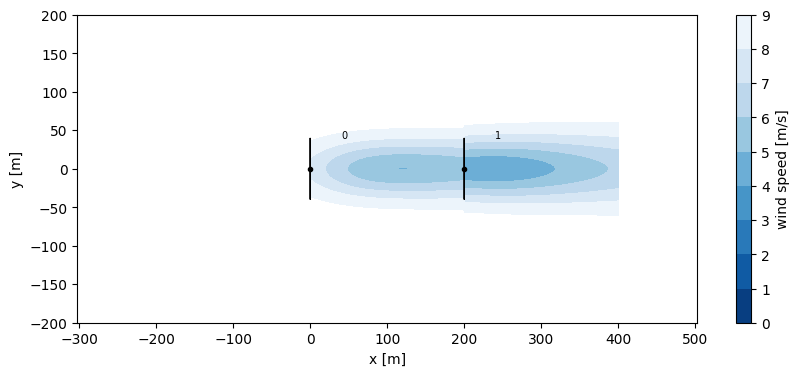

In [143]:
from py_wake.superposition_models import SqrMaxSum

sqr_max_sum = Zong_PorteAgel_2020(site, windTurbines, use_effective_ws=True, superpositionModel=WeightedSum(),
                                  turbulenceModel=CrespoHernandez(addedTurbulenceSuperpositionModel=SqrMaxSum()))
plt.figure(figsize=(10,4))
sqr_max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

---

# Blockage Deficit Models

- O Blockage ao contrário dos modelos de efeito esteira, que descreve a redução da velocidade depois da turbina, o blockage descreve a redução do vento antes da turbina.
- Nesse capítulo apresentaremos os modelos de blockage e as suas funcionalidades.

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

In [145]:
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.wind_farm_models import All2AllIterative

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_blockage_deficit_map(model):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap), levels=np.linspace(-3.5,3.5,113))

# Modelos de blockage apresentados pelo pywake:

- SelfSimilarityDeficit: Este modelo se baseia na teoria do disco atuador e em princípios de auto-similaridade para descrever o déficit de velocidade a montante de uma turbina. Ele modela a desaceleração do fluxo de vento na frente do rotor.

- SelfSimilarityDeficit2020: Esse modelo, é uma versão atualizada do anterior.

- FugaDeficit: O FugaDeficit não é apenas um modelo blockage, mas um modelo de efeito esteira completo. Ele calcula tudo com base em tabelas de consulta pré-computadas.

- VortexCylindar: Este modelo representa a indução por um cilindro de vórtices tangenciais semi-infinito que se estende ao longo do eixo x.

- VortexDipole: Representa a vorticidade originada de uma turbina eólica por uma linha de dipolo de vórtice. A indução estimada por essa representação é muito similar aos resultados de 
modelos mais complexos como o VortexCylinder.

- RankineHalfBody: Um modelo de indução simples que para representar a indução introduzida por uma turbina. A intensidade da "fonte" que gera esse corpo é determinada impondo um balanço de quantidade de movimento 1D no plano do rotor.

- HybridInduction: Ele combina um modelo similar ao VortexDipole para o campo distante com um modelo de auto-similaridade otimizado para o campo próximo. O objetivo é reduzir o esforço computacional e capturar a redistribuição de energia pelo bloqueio. 

- Rathmann: É comparável ao método do dipolo de vórtice, dando um campo de fluxo quase idêntico ao modelo VortexCylinder. Seu déficit na linha central é idêntico ao do VortexCylinder, mas usa uma função de forma radial que depende da abertura do cilindro de vórtice visto de um ponto a montante. Para simular o "speed-up" a jusante, o déficit é espelhado no plano do rotor com uma mudança de sinal.

# SelfSimilarityDeficit

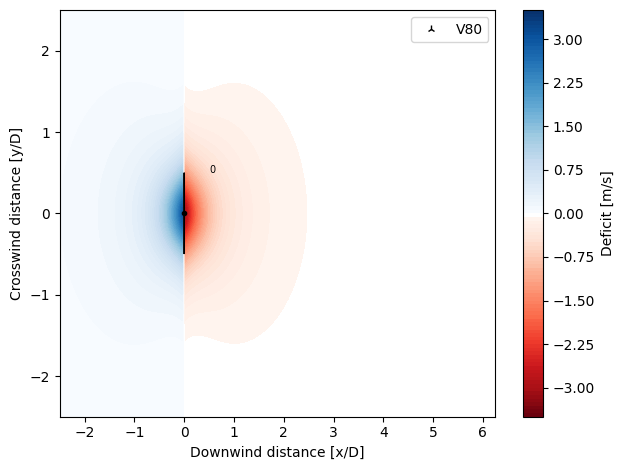

In [146]:
from py_wake.deficit_models import SelfSimilarityDeficit
plot_blockage_deficit_map(SelfSimilarityDeficit())

# SelfSimilarityDeficit2020

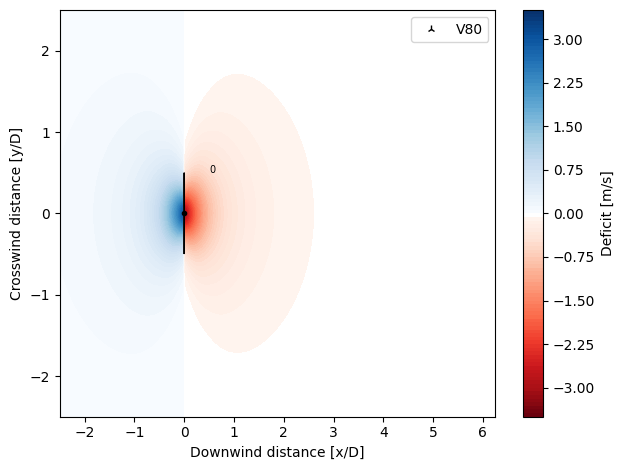

In [147]:
from py_wake.deficit_models import SelfSimilarityDeficit2020
plot_blockage_deficit_map(SelfSimilarityDeficit2020())

# FugaDeficit

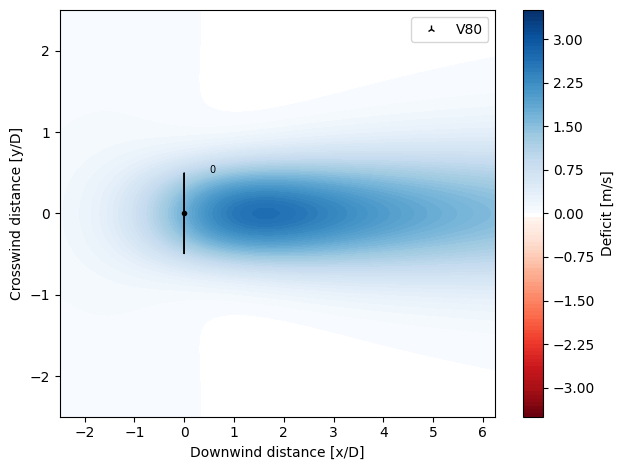

In [148]:
from py_wake.deficit_models import FugaDeficit
plot_blockage_deficit_map(FugaDeficit())

# VortexCylindar

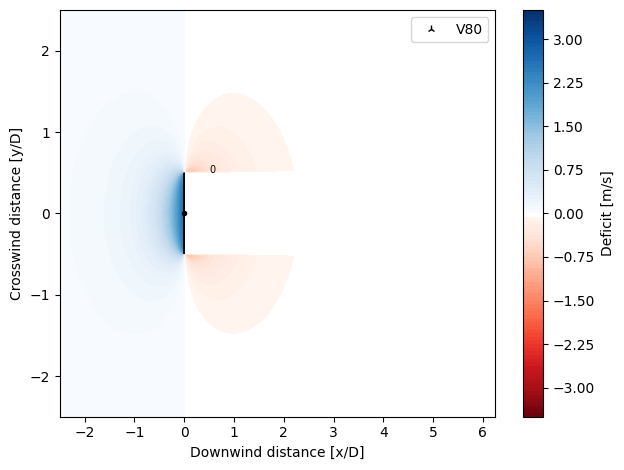

In [149]:
from py_wake.deficit_models import VortexCylinder
plot_blockage_deficit_map(VortexCylinder())

# VortexDipole

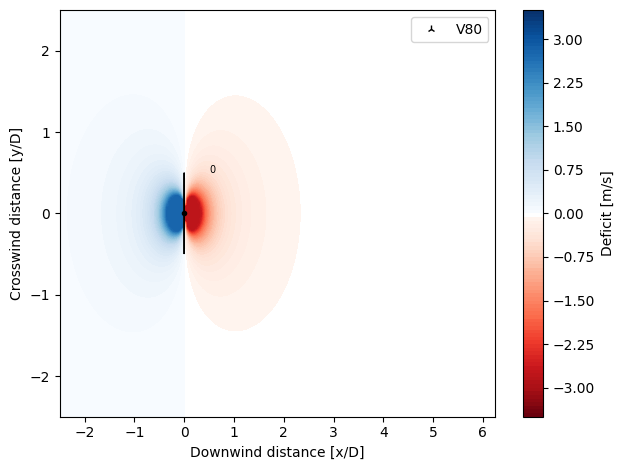

In [150]:
from py_wake.deficit_models import VortexDipole
plot_blockage_deficit_map(VortexDipole())

# RankineHalfBody

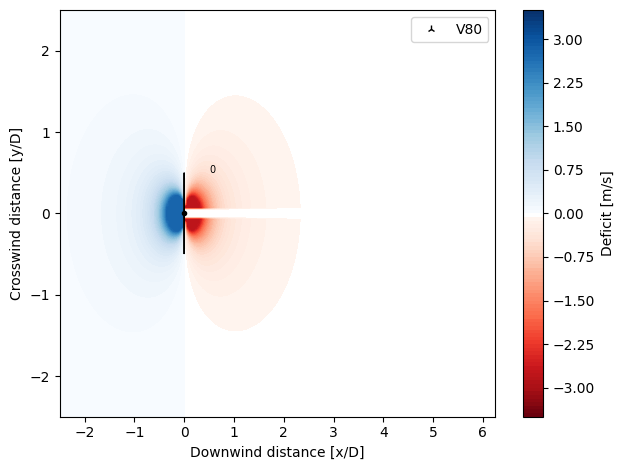

In [151]:
from py_wake.deficit_models import RankineHalfBody
plot_blockage_deficit_map(RankineHalfBody())

# HybridInduction

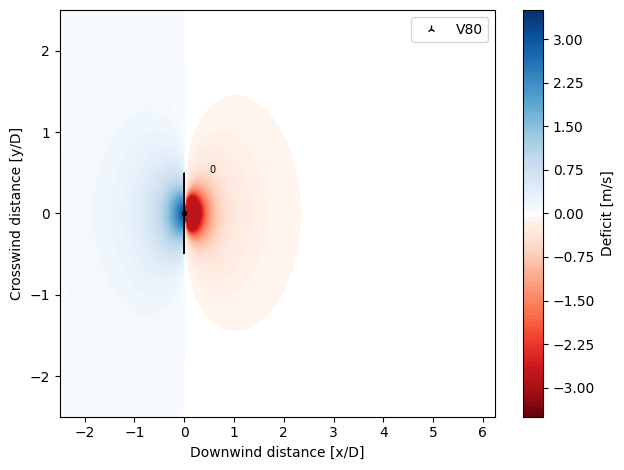

In [152]:
from py_wake.deficit_models import HybridInduction
plot_blockage_deficit_map(HybridInduction())

# Rathmann

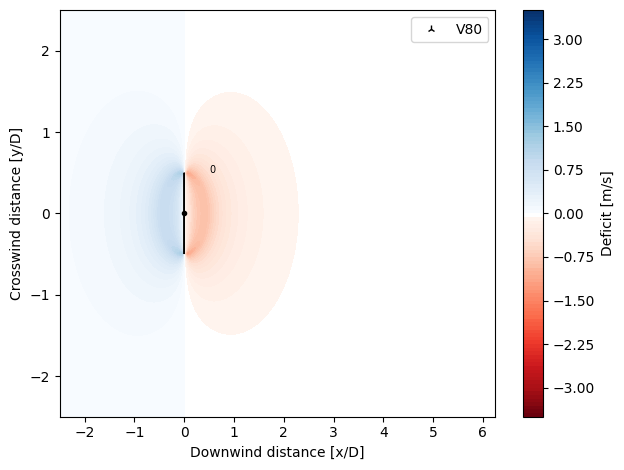

In [153]:
from py_wake.deficit_models import Rathmann
plot_blockage_deficit_map(Rathmann())

---

# Vamos praticar:
- Vamos fazer uma simulação de efeito esteira, mas agora vamos adicionar as Superposições e o Blockage.

In [165]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients
import topfarm

In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines import WindTurbine, WindTurbines

- Primeiro vamos criar a nossa turbina

In [167]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd

u= [0,3,5,7,9,11,13,15,17,19,21]
ct= [0,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8]
power= [0,0,0,0,0,0,49, 127, 224, 339, 480]

turbina= WindTurbine(name='MyWT',
                    diameter=136,
                    hub_height=100,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

- Em seguida vamos criar o nosso site

In [168]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

In [169]:
Weibull_A = np.array(A)
Weibull_k = np.array(k)
#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"

site_1 = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', Weibull_A),
        'Weibull_k': ('wd', Weibull_k),
        'TI': (ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
    }
)

- Agora vamos criar a nossa simulação WindFarm

In [170]:
from py_wake import NOJ
windTurbines = wt
site = XRSite(site_1)

In [189]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.superposition_models import MaxSum, WeightedSum
from py_wake.deficit_models import BastankhahGaussianDeficit, FugaDeficit, NiayifarGaussianDeficit

wf_model = All2AllIterative(site, turbina,
                            wake_deficitModel=FugaDeficit(),
                            superpositionModel=MaxSum(),
                            blockage_deficitModel=FugaDeficit())

- Passamos as coordenadas das nossas turbinas eolicas

In [190]:
layout_x=[420, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
layout_y=[0,210,410,610,810,1010,1210,1410,1610,1810]

In [191]:
simulaçaoResult = wf_model(layout_x, layout_y, wd=150, ws=10)

In [192]:
simulaçaoResult

<xarray.SimulationResult> Size: 816B
Dimensions:           (wt: 10, wd: 1, ws: 1)
Coordinates:
  * wt                (wt) int64 80B 0 1 2 3 4 5 6 7 8 9
  * wd                (wd) int64 8B 150
  * ws                (ws) int64 8B 10
    type              (wt) int64 80B 0 0 0 0 0 0 0 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 80B 9.958 9.748 9.988 ... 9.988 10.0
    TI_eff            (wt, wd, ws) float64 80B 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 80B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CT                (wt, wd, ws) float64 80B 0.8889 0.8889 ... 0.8889 0.8889
    h                 (wt) float64 80B 100.0 100.0 100.0 ... 100.0 100.0 100.0
    x                 (wt) int64 80B 420 200 400 600 800 ... 1200 1400 1600 1800
    ...                ...
    ws_l              float64 8B 9.5
    ws_u              float64 8B 10.5
    Weibull_A         float64 8B 9.594
    Weibull_k         float64 8B 2.596
    Sector_frequency  float64 8B 0.768
    P                 float64 8B 0.07277

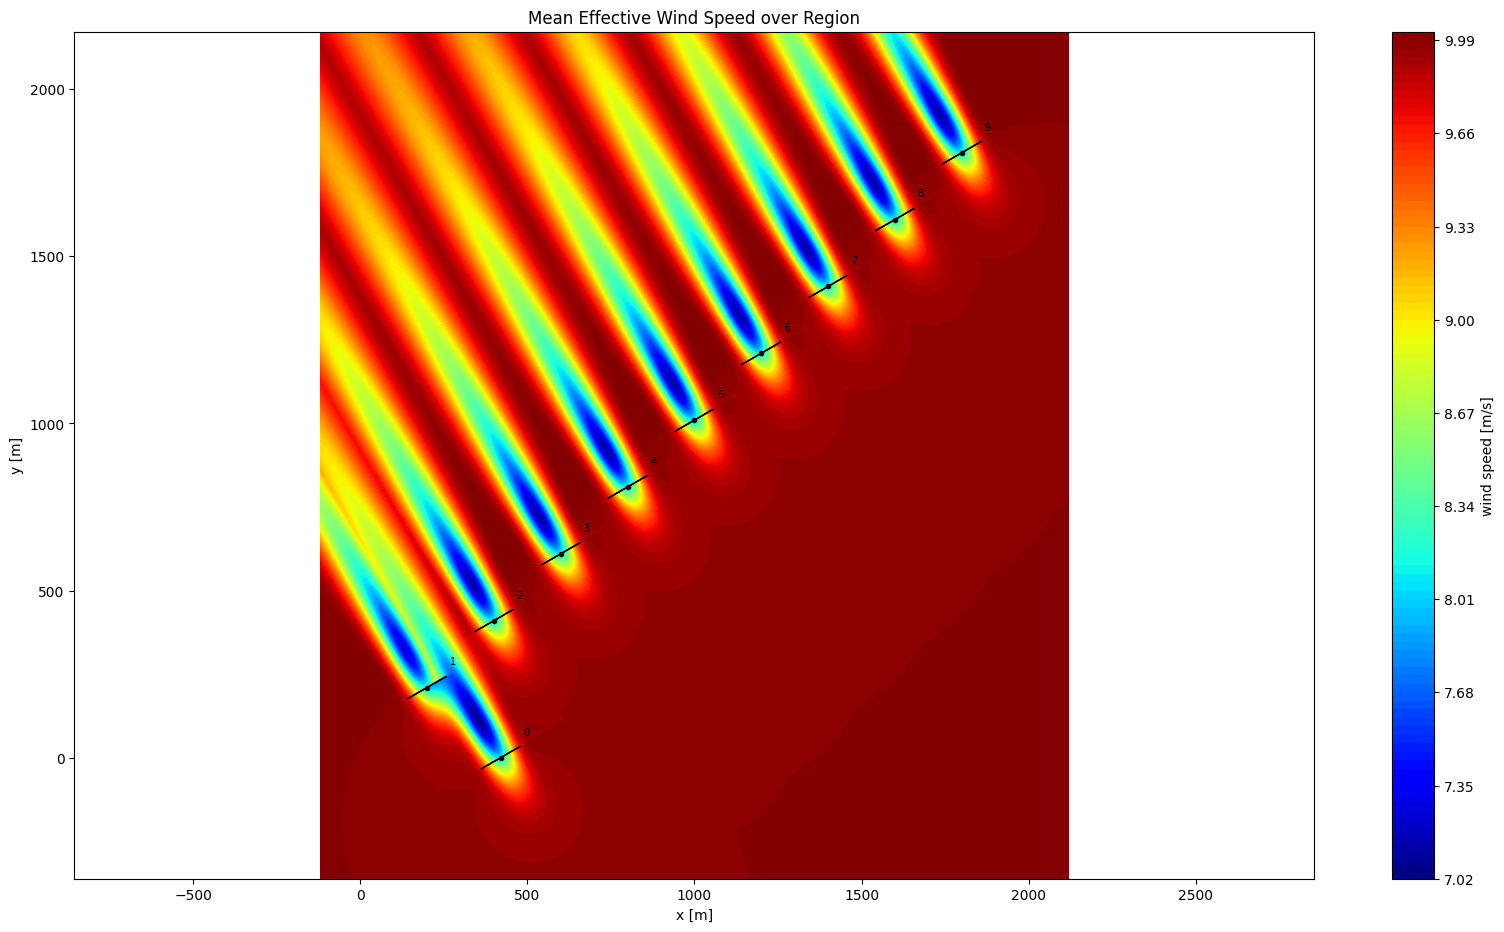

Tempo de execução: 6091051500


In [193]:
import time
start_time = time.perf_counter_ns()
flow = simulaçaoResult.flow_map()
plt.figure(figsize=(20, 11))
flow.plot_wake_map(cmap='jet')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()
end_time = time.perf_counter_ns()
elapsed_time = end_time - start_time
print(f"Tempo de execução: {elapsed_time}")